In [1]:
%load_ext lab_black

In [2]:
%config Completer.use_jedi = False

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time
from contextlib import contextmanager
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer, StandardScaler

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
)
from sklearn.neural_network import MLPRegressor

In [4]:
@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
    if prefix:
        format_str = str(prefix) + format_str
    if suffix:
        format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [5]:
path = "input"

In [31]:
train = pd.read_csv(path + "/train.csv", index_col=["id"])
test = pd.read_csv(path + "/test.csv", index_col=["id"])
submission = pd.read_csv(path + "/sample_submission.csv", index_col=["id"])

In [32]:
features = [
    "cont1",
    "cont2",
    "cont3",
    "cont4",
    "cont5",
    "cont6",
    "cont7",
    "cont8",
    "cont9",
    "cont10",
    "cont11",
    "cont12",
    "cont13",
    "cont14",
]

In [33]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [249]:
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "n_estimators": 1_000,
    "learning_rate": 0.05,
    #     "max_depth": -1,
    "importance_type": "gain",
}

xgb_params = {"n_estimators": 1_000, "learning_rate": 0.05}

cgb_params = {
    "n_estimators": 1_000,
    "learning_rate": 0.05,
    "verbose": False,
}

ngb_params = {"n_estimators": 1_000, "learning_rate": 0.05}

In [250]:
# create a list of base-models
def get_models():
    models = list()
    models.append(LinearRegression())
    #     models.append(SVR())
    #     models.append(MLPRegressor())
    #     models.append(AdaBoostRegressor()),
    #     models.append(BaggingRegressor()),
    #     models.append(GradientBoostingRegressor()),
    #     models.append(RandomForestRegressor()),
    models.append(LGBMRegressor(**lgb_params))
    models.append(XGBRegressor(**xgb_params))
    models.append(CatBoostRegressor(**cgb_params))
    #     models.append(NGBRegressor(**ngb_params))

    return models

In [242]:
def get_oof_pred(X, y, nfold, models):
    meta_X = pd.DataFrame()

    for i, model in tqdm(enumerate(models), total=len(models)):

        oof_pred = np.zeros_like(y)

        seed = np.random.randint(0, 10_000)
        cv = list(KFold(n_splits=nfold, shuffle=True, random_state=seed).split(X))
        for j, (train_idx, valid_idx) in tqdm(enumerate(cv), total=len(cv)):
            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]

            if model.__class__.__name__ == "LGBMRegressor":
                model.fit(
                    X_train,
                    y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    eval_names=["Train", "Valid"],
                    early_stopping_rounds=50,
                    verbose=500,
                )

            elif model.__class__.__name__ == "XGBRegressor":
                model.fit(
                    X_train,
                    y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    eval_metric="rmse",
                    early_stopping_rounds=50,
                    verbose=500,
                )
            elif model.__class__.__name__ == "CatBoostRegressor":
                model.fit(
                    X_train,
                    y_train,
                    use_best_model=True,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    early_stopping_rounds=50,
                    verbose_eval=500,
                )
            elif model.__class__.__name__ == "NGBRegressor":
                model.fit(
                    X_train,
                    y_train,
                    X_val=X_valid,
                    Y_val=y_valid,
                    early_stopping_rounds=50,
                )
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_valid)
            oof_pred[valid_idx] = y_pred

        meta_X[f"{model.__class__.__name__}"] = oof_pred
        print(
            f"{model.__class__.__name__} Out of Fold RMSE: {rmse_score(y, oof_pred):.3f}"
        )

    return meta_X.add_prefix("model_")

In [243]:
def fit_base_models(X, y, models):
    for model in tqdm(models, total=len(models)):
        print(model.__class__.__name__)
        model.fit(X, y)

In [244]:
def fit_meta_model(X, y):
    model = Ridge(fit_intercept=False)
    model.fit(X, y)
    return model

In [245]:
def evaluate_models(X, y, models):
    for model in tqdm(models, total=len(models)):
        y_pred = model.predict(X)
        score = rmse_score(y, y_pred)
        print(f"{model.__class__.__name__}: RMSE {score:.3f}")

In [246]:
def super_learner_predict(X, models, meta_model):
    meta_X = pd.DataFrame()
    for i, model in tqdm(enumerate(models), total=len(models)):
        meta_X[f"{model.__class__.__name__}"] = model.predict(X)
    return meta_X, meta_model.predict(meta_X)

In [251]:
X, X_val, y, y_val = train_test_split(train[features], train["target"], test_size=0.3)

models = get_models()

In [248]:
meta_X = get_oof_pred(X.values, y.values, 5, models)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

LinearRegression Out of Fold RMSE: 0.727


  0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[500]	Train's rmse: 0.677124	Valid's rmse: 0.702619
Early stopping, best iteration is:
[752]	Train's rmse: 0.665837	Valid's rmse: 0.702258
Training until validation scores don't improve for 50 rounds
[500]	Train's rmse: 0.676729	Valid's rmse: 0.701593
Early stopping, best iteration is:
[889]	Train's rmse: 0.659379	Valid's rmse: 0.700802
Training until validation scores don't improve for 50 rounds
[500]	Train's rmse: 0.676759	Valid's rmse: 0.703128
Early stopping, best iteration is:
[649]	Train's rmse: 0.670097	Valid's rmse: 0.702754
Training until validation scores don't improve for 50 rounds
[500]	Train's rmse: 0.677168	Valid's rmse: 0.701279
Early stopping, best iteration is:
[919]	Train's rmse: 0.658545	Valid's rmse: 0.700584
Training until validation scores don't improve for 50 rounds
[500]	Train's rmse: 0.67715	Valid's rmse: 0.701528
Early stopping, best iteration is:
[774]	Train's rmse: 0.664584	Valid's rmse: 0.700973
L

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-rmse:7.07169	validation_1-rmse:7.07354
[500]	validation_0-rmse:0.67041	validation_1-rmse:0.70046
[660]	validation_0-rmse:0.66269	validation_1-rmse:0.70030
[0]	validation_0-rmse:7.07275	validation_1-rmse:7.06902
[500]	validation_0-rmse:0.66837	validation_1-rmse:0.70447
[553]	validation_0-rmse:0.66577	validation_1-rmse:0.70448
[0]	validation_0-rmse:7.07171	validation_1-rmse:7.07345
[500]	validation_0-rmse:0.66880	validation_1-rmse:0.70147
[771]	validation_0-rmse:0.65670	validation_1-rmse:0.70114
[0]	validation_0-rmse:7.07213	validation_1-rmse:7.07173
[500]	validation_0-rmse:0.66862	validation_1-rmse:0.70355
[655]	validation_0-rmse:0.66144	validation_1-rmse:0.70352
[0]	validation_0-rmse:7.07195	validation_1-rmse:7.07252
[500]	validation_0-rmse:0.66843	validation_1-rmse:0.70361
[711]	validation_0-rmse:0.65871	validation_1-rmse:0.70356
XGBRegressor Out of Fold RMSE: 0.703


  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.7337526	test: 0.7337526	test1: 0.7314625	best: 0.7314625 (0)	total: 23.4ms	remaining: 35.1s
500:	learn: 0.6979242	test: 0.6979242	test1: 0.7028244	best: 0.7028244 (500)	total: 7.7s	remaining: 15.3s
1000:	learn: 0.6867667	test: 0.6867667	test1: 0.6998581	best: 0.6998578 (997)	total: 16.1s	remaining: 8s
1499:	learn: 0.6777690	test: 0.6777690	test1: 0.6987312	best: 0.6987312 (1499)	total: 23.2s	remaining: 0us

bestTest = 0.6987311597
bestIteration = 1499

0:	learn: 0.7330150	test: 0.7330150	test1: 0.7343866	best: 0.7343866 (0)	total: 16.6ms	remaining: 24.9s
500:	learn: 0.6970227	test: 0.6970227	test1: 0.7061218	best: 0.7061218 (500)	total: 7.43s	remaining: 14.8s
1000:	learn: 0.6859779	test: 0.6859779	test1: 0.7033809	best: 0.7033809 (1000)	total: 14.7s	remaining: 7.31s
1499:	learn: 0.6771605	test: 0.6771605	test1: 0.7023507	best: 0.7023507 (1499)	total: 21.7s	remaining: 0us

bestTest = 0.7023507071
bestIteration = 1499

0:	learn: 0.7328725	test: 0.7328725	test1: 0.7350309	best

In [252]:
meta_X.corr()

,model_LinearRegression_col0,model_LGBMRegressor_col1,model_XGBRegressor_col2,model_CatBoostRegressor_col3
model_LinearRegression_col0,1.000000,0.478177,0.482169,0.484073
model_LGBMRegressor_col1,0.478177,1.000000,0.930020,0.938704
model_XGBRegressor_col2,0.482169,0.930020,1.000000,0.935422
model_CatBoostRegressor_col3,0.484073,0.938704,0.935422,1.000000


In [253]:
fit_base_models(X.values, y.values, models)

  0%|          | 0/4 [00:00<?, ?it/s]

LinearRegression
LGBMRegressor
XGBRegressor
CatBoostRegressor


In [254]:
evaluate_models(X_val.values, y_val.values, models)

  0%|          | 0/4 [00:00<?, ?it/s]

LinearRegression: RMSE 0.725
LGBMRegressor: RMSE 0.699
XGBRegressor: RMSE 0.700
CatBoostRegressor: RMSE 0.700


In [262]:
meta_model = fit_meta_model(meta_X.iloc[:, 1:].values, y.values)

print(meta_model.coef_, meta_model.intercept_)

[0.30624679 0.36988678 0.32343204] 0.0


In [263]:
meta_X_val, y_pred = super_learner_predict(X_val.values, models[1:], meta_model)

  0%|          | 0/3 [00:00<?, ?it/s]

In [264]:
print(f"Super Learner: RMSE {rmse_score(y_val, y_pred):.3f}")

Super Learner: RMSE 0.698


In [265]:
y_pred = np.array([model.predict(X_val.values) for model in models[1:]])

y_pred = np.mean(y_pred, axis=0)

print(f"Super Learner: RMSE {rmse_score(y_val, y_pred):.3f}")

Super Learner: RMSE 0.698


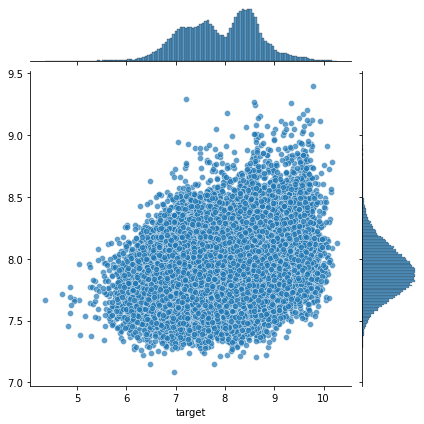

In [266]:
sns.jointplot(x=y_val, y=y_pred, joint_kws={"alpha": 0.7})

In [191]:
submission["target"] = super_learner_predict(test, models, meta_model)

  0%|          | 0/6 [00:00<?, ?it/s]

In [193]:
submission.to_csv("output/submission.csv")